In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [50]:
import pandas as pd
import numpy as np
import graphviz
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GRU
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
from sklearn.tree import plot_tree

In [51]:
file_path = '/content/drive/MyDrive/Colab Datos/Proyecto/Detenciones_editado.csv'
detenciones_df = pd.read_csv(file_path, delimiter=';', encoding='latin1')

In [52]:
detenciones_df.head()

,Mes,DSP_MAQUINA_LOG,LIDER,DSP_LIDER,PLANTA,DSP_PLANTA,AREA,FECHA,TURNO,TIPO_DETENCION,...,L2,ID_MAQUINA_FIS,DSP_MAQUINA_FIS,ID_MAQUINA_LOG,Detención,Tipo de parada,Clasificación \nde parada,Clasificación 2,Fecha + turno,% OEE Pérdido Interno
0,ene-23,Linea De Alimentación Springer Aserradero,12983093,Bustos Jerez Victor Gabriel,1,MULCHEN,Línea de aserrío,03-01-2023 0:00,3,Operacional,...,0,1105000,E-180 Transporte De Salida Girador De Trozos,1100000,Trozo Quebrado,Detención organizacional,Operacional,Trozo,44929 - 3,"0,05%"
1,ene-23,Sierra Huincha Twin Ebt2-1800,12983093,Bustos Jerez Victor Gabriel,1,MULCHEN,Línea de aserrío,03-01-2023 0:00,3,Sierras,...,0,1114500,310 Sierra Huincha Twin Ebt2 - 1800,1114500,Cambio E Corte Raya > 10 Min.,Detención organizacional,Operacional,Sierras,44929 - 3,"0,05%"
2,ene-23,SUBPRODUCTOS P1,12983093,Bustos Jerez Victor Gabriel,1,MULCHEN,Línea de aserrío,03-01-2023 0:00,3,Operacional,...,0,11695-00,1050 Mesa De Receptora Reproceso Linea Subp...,127340,Lleno o Atorado Por Madera,Detención organizacional,Operacional,LLeno o atorado,44929 - 3,"0,19%"
3,ene-23,Sierra Huincha Twin Ebt2-1800,12983093,Bustos Jerez Victor Gabriel,1,MULCHEN,Línea de aserrío,03-01-2023 0:00,3,Sierras,...,0,1114500,310 Sierra Huincha Twin Ebt2 - 1800,1114500,Cambio E Corte Raya > 10 Min.,Detención organizacional,Operacional,Sierras,44929 - 3,"0,05%"
4,ene-23,Sierra Huincha Twin Ebt2-1800,12983093,Bustos Jerez Victor Gabriel,1,MULCHEN,Línea de aserrío,03-01-2023 0:00,3,Operacional,...,0,1115500,340 Mesa Receptora Laterales Nqf/S Twin,1114500,Lleno o Atorado Por Madera,Detención organizacional,Operacional,LLeno o atorado,44929 - 3,"0,02%"


# Pre-Procesamiento de los datos

In [53]:
detenciones_df = detenciones_df.drop_duplicates()

In [54]:
detenciones_df = detenciones_df.dropna()

In [55]:
detenciones_df['FECHA'] = detenciones_df['FECHA'].str.split(' ').str[0]
detenciones_df['FECHA'] = pd.to_datetime(detenciones_df['FECHA'], format='%d-%m-%Y')
detenciones_df['INICIO_DET'] = pd.to_datetime(detenciones_df['FECHA'].astype(str) + ' ' + detenciones_df['INICIO_DET'])
detenciones_df['TERMINO_DET'] = pd.to_datetime(detenciones_df['FECHA'].astype(str) + ' ' + detenciones_df['TERMINO_DET'])

In [56]:
detenciones_df['ES_DETENCION'] = 1

In [57]:
detenciones_df.sort_values(by='INICIO_DET', inplace=True)

In [58]:
detenciones_df.head()

,Mes,DSP_MAQUINA_LOG,LIDER,DSP_LIDER,PLANTA,DSP_PLANTA,AREA,FECHA,TURNO,TIPO_DETENCION,...,ID_MAQUINA_FIS,DSP_MAQUINA_FIS,ID_MAQUINA_LOG,Detención,Tipo de parada,Clasificación \nde parada,Clasificación 2,Fecha + turno,% OEE Pérdido Interno,ES_DETENCION
16,ene-23,Canteadora Optimes N°2,19052460,CAMPOS SEBASTIAN IGNACIO,1,MULCHEN,Línea de aserrío,2023-01-03,2,Operacional,...,1140000,840 Transporte De Salida Asv-Bko Canteadora ...,1140500,Resetear Equipos,Detención organizacional,Operacional,Otros,44929 - 2,"0,10%",1
17,ene-23,Sierra Huincha Twin Ebt2-1800,19052460,CAMPOS SEBASTIAN IGNACIO,1,MULCHEN,Línea de aserrío,2023-01-03,2,Sierras,...,1114500,310 Sierra Huincha Twin Ebt2 - 1800,1114500,Cambio E Corte Raya > 10 Min.,Detención organizacional,Operacional,Sierras,44929 - 2,"0,05%",1
20,ene-23,Linea De Alimentación Springer Aserradero,19052460,CAMPOS SEBASTIAN IGNACIO,1,MULCHEN,Línea de aserrío,2023-01-03,2,Mecanica,...,1104500,E-140 Girador De Trozos Log Turner,1100000,Cambiar y/o Instalar Soporte,Detención Técnica,Mecanica,0,44929 - 2,"0,09%",1
18,ene-23,Linea De Alimentación Springer Aserradero,19052460,CAMPOS SEBASTIAN IGNACIO,1,MULCHEN,Línea de aserrío,2023-01-03,2,Operacional,...,1102000,E-30 Mesa De Transporte Inclinada N° 1 Springer,1100000,Trozo Atravesado,Detención organizacional,Operacional,Trozo,44929 - 2,"0,03%",1
19,ene-23,Linea De Alimentación Springer Aserradero,19052460,CAMPOS SEBASTIAN IGNACIO,1,MULCHEN,Línea de aserrío,2023-01-03,2,Mecanica,...,1104500,E-140 Girador De Trozos Log Turner,1100000,Cambiar y/o Instalar Soporte,Detención Técnica,Mecanica,0,44929 - 2,"0,08%",1


In [59]:
from datetime import timedelta

# Definimos una lista para guardar los registros de no detencion
nuevos_registros = []

# Iteraramos sobre las filas para identificar los intervalos sin detenciones
for i in range(len(detenciones_df) - 1):
    current_end = detenciones_df.iloc[i]['TERMINO_DET']
    next_start = detenciones_df.iloc[i + 1]['INICIO_DET']

    # Por temas de negocio se define que el intervalo mínimo para colocar una no detención es de 30 minutos
    if next_start - current_end >= timedelta(minutes=30):
        nuevos_registros.append({
            'FECHA': current_end.date(),
            'INICIO_DET': current_end,
            'TERMINO_DET': next_start,
            'TIPO_DETENCION': 'No Detención',
            'ES_DETENCION': 0
        })

In [60]:
nuevos_registros_df = pd.DataFrame(nuevos_registros)
detenciones_df = pd.concat([detenciones_df, nuevos_registros_df], ignore_index=True)

In [61]:
detenciones_df.sort_values(by='INICIO_DET', inplace=True)

In [62]:
detenciones_df.head()

,Mes,DSP_MAQUINA_LOG,LIDER,DSP_LIDER,PLANTA,DSP_PLANTA,AREA,FECHA,TURNO,TIPO_DETENCION,...,ID_MAQUINA_FIS,DSP_MAQUINA_FIS,ID_MAQUINA_LOG,Detención,Tipo de parada,Clasificación \nde parada,Clasificación 2,Fecha + turno,% OEE Pérdido Interno,ES_DETENCION
0,ene-23,Canteadora Optimes N°2,19052460.0,CAMPOS SEBASTIAN IGNACIO,1.0,MULCHEN,Línea de aserrío,2023-01-03 00:00:00,2.0,Operacional,...,1140000,840 Transporte De Salida Asv-Bko Canteadora ...,1140500.0,Resetear Equipos,Detención organizacional,Operacional,Otros,44929 - 2,"0,10%",1
1,ene-23,Sierra Huincha Twin Ebt2-1800,19052460.0,CAMPOS SEBASTIAN IGNACIO,1.0,MULCHEN,Línea de aserrío,2023-01-03 00:00:00,2.0,Sierras,...,1114500,310 Sierra Huincha Twin Ebt2 - 1800,1114500.0,Cambio E Corte Raya > 10 Min.,Detención organizacional,Operacional,Sierras,44929 - 2,"0,05%",1
2,ene-23,Linea De Alimentación Springer Aserradero,19052460.0,CAMPOS SEBASTIAN IGNACIO,1.0,MULCHEN,Línea de aserrío,2023-01-03 00:00:00,2.0,Mecanica,...,1104500,E-140 Girador De Trozos Log Turner,1100000.0,Cambiar y/o Instalar Soporte,Detención Técnica,Mecanica,0,44929 - 2,"0,09%",1
3,ene-23,Linea De Alimentación Springer Aserradero,19052460.0,CAMPOS SEBASTIAN IGNACIO,1.0,MULCHEN,Línea de aserrío,2023-01-03 00:00:00,2.0,Operacional,...,1102000,E-30 Mesa De Transporte Inclinada N° 1 Springer,1100000.0,Trozo Atravesado,Detención organizacional,Operacional,Trozo,44929 - 2,"0,03%",1
4,ene-23,Linea De Alimentación Springer Aserradero,19052460.0,CAMPOS SEBASTIAN IGNACIO,1.0,MULCHEN,Línea de aserrío,2023-01-03 00:00:00,2.0,Mecanica,...,1104500,E-140 Girador De Trozos Log Turner,1100000.0,Cambiar y/o Instalar Soporte,Detención Técnica,Mecanica,0,44929 - 2,"0,08%",1


In [64]:
no_detenciones_df = detenciones_df[detenciones_df['ES_DETENCION'] == 0]
no_detenciones_df.head()

,Mes,DSP_MAQUINA_LOG,LIDER,DSP_LIDER,PLANTA,DSP_PLANTA,AREA,FECHA,TURNO,TIPO_DETENCION,...,ID_MAQUINA_FIS,DSP_MAQUINA_FIS,ID_MAQUINA_LOG,Detención,Tipo de parada,Clasificación \nde parada,Clasificación 2,Fecha + turno,% OEE Pérdido Interno,ES_DETENCION
6024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-03,NaN,No Detención,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
6025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-03,NaN,No Detención,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
6026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-03,NaN,No Detención,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
6027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-03,NaN,No Detención,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
6028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-03,NaN,No Detención,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [66]:
# Se guarda el archivo preprocesado para su eventual uso
output_file_path = '/content/drive/MyDrive/Colab Datos/Proyecto/Detenciones_preprocesado.csv'
detenciones_df.to_csv(output_file_path, index=False)

In [67]:
detenciones_df = pd.read_csv('/content/drive/MyDrive/Colab Datos/Proyecto/Detenciones_preprocesado.csv')

In [68]:
detenciones_df['INICIO_DET'] = pd.to_datetime(detenciones_df['INICIO_DET'])
detenciones_df['TERMINO_DET'] = pd.to_datetime(detenciones_df['TERMINO_DET'])
detenciones_df['DIA'] = detenciones_df['INICIO_DET'].dt.day
detenciones_df['MES'] = detenciones_df['INICIO_DET'].dt.month
detenciones_df['HORA'] = detenciones_df['INICIO_DET'].dt.hour
detenciones_df['MINUTO'] = detenciones_df['INICIO_DET'].dt.minute

In [69]:
detenciones_df['DURACION_DET'] = (detenciones_df['TERMINO_DET'] - detenciones_df['INICIO_DET']).dt.total_seconds() / 60  # Duración en minutos
detenciones_df['TIEMPO_DESDE_ULTIMA'] = detenciones_df['INICIO_DET'].diff().dt.total_seconds() / 60  # Tiempo desde la última detención


detenciones_df['TIEMPO_DESDE_ULTIMA'].fillna(0, inplace=True)

detenciones_df['DURACION_DET'].fillna(0, inplace=True)

In [70]:
detenciones_df.head()

,Mes,DSP_MAQUINA_LOG,LIDER,DSP_LIDER,PLANTA,DSP_PLANTA,AREA,FECHA,TURNO,TIPO_DETENCION,...,Clasificación 2,Fecha + turno,% OEE Pérdido Interno,ES_DETENCION,DIA,MES,HORA,MINUTO,DURACION_DET,TIEMPO_DESDE_ULTIMA
0,ene-23,Canteadora Optimes N°2,19052460.0,CAMPOS SEBASTIAN IGNACIO,1.0,MULCHEN,Línea de aserrío,2023-01-03 00:00:00,2.0,Operacional,...,Otros,44929 - 2,"0,10%",1,3,1,8,0,38.0,0.0
1,ene-23,Sierra Huincha Twin Ebt2-1800,19052460.0,CAMPOS SEBASTIAN IGNACIO,1.0,MULCHEN,Línea de aserrío,2023-01-03 00:00:00,2.0,Sierras,...,Sierras,44929 - 2,"0,05%",1,3,1,8,55,10.0,55.0
2,ene-23,Linea De Alimentación Springer Aserradero,19052460.0,CAMPOS SEBASTIAN IGNACIO,1.0,MULCHEN,Línea de aserrío,2023-01-03 00:00:00,2.0,Mecanica,...,0,44929 - 2,"0,09%",1,3,1,9,20,16.0,25.0
3,ene-23,Linea De Alimentación Springer Aserradero,19052460.0,CAMPOS SEBASTIAN IGNACIO,1.0,MULCHEN,Línea de aserrío,2023-01-03 00:00:00,2.0,Operacional,...,Trozo,44929 - 2,"0,03%",1,3,1,9,48,6.0,28.0
4,ene-23,Linea De Alimentación Springer Aserradero,19052460.0,CAMPOS SEBASTIAN IGNACIO,1.0,MULCHEN,Línea de aserrío,2023-01-03 00:00:00,2.0,Mecanica,...,0,44929 - 2,"0,08%",1,3,1,10,0,15.0,12.0


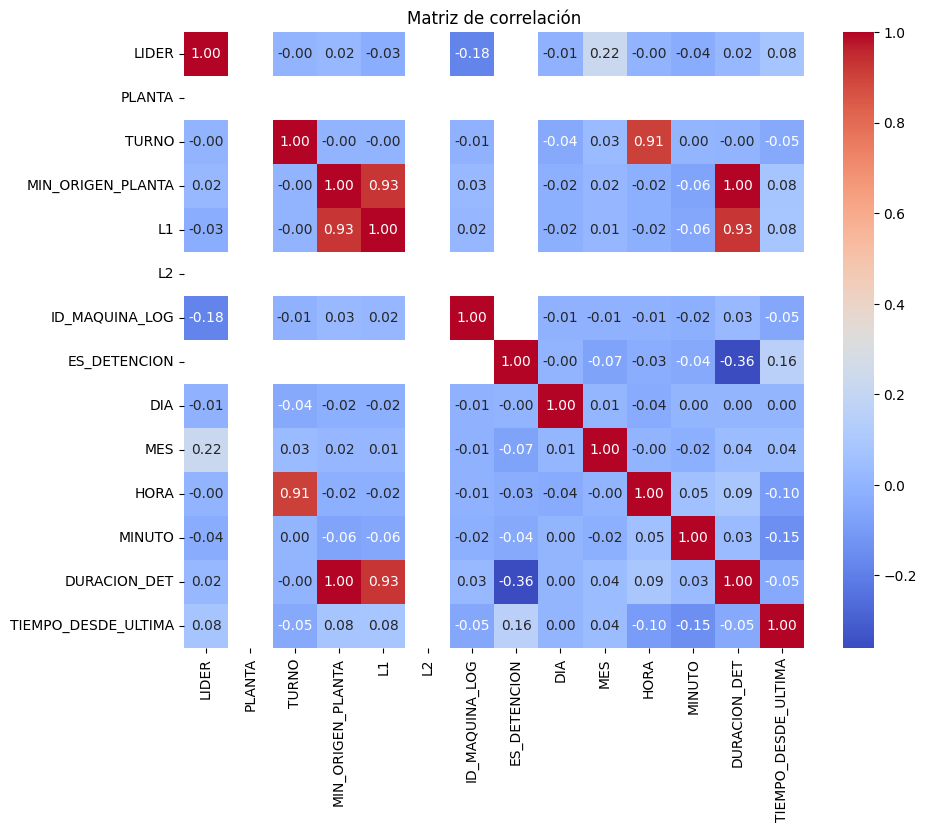

In [73]:
numeric_df = detenciones_df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de correlación')
plt.show()

Etiquetas

In [74]:
X = detenciones_df[['DIA', 'MES', 'HORA', 'MINUTO', 'DURACION_DET', 'TIEMPO_DESDE_ULTIMA']]
y = detenciones_df['ES_DETENCION']

Datos entrenamiento

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [76]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [77]:
scaler = StandardScaler()
X_train_smote = scaler.fit_transform(X_train_smote)
X_test = scaler.transform(X_test)

# Modelos

Random Forest

In [80]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train_smote, y_train_smote)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest")
print(classification_report(y_test, y_pred_rf))
print(f"Precisión: {accuracy_score(y_test, y_pred_rf)}\n")

Random Forest
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       468
           1       0.99      0.98      0.99      1212

    accuracy                           0.98      1680
   macro avg       0.97      0.98      0.98      1680
weighted avg       0.98      0.98      0.98      1680

Precisión: 0.9803571428571428



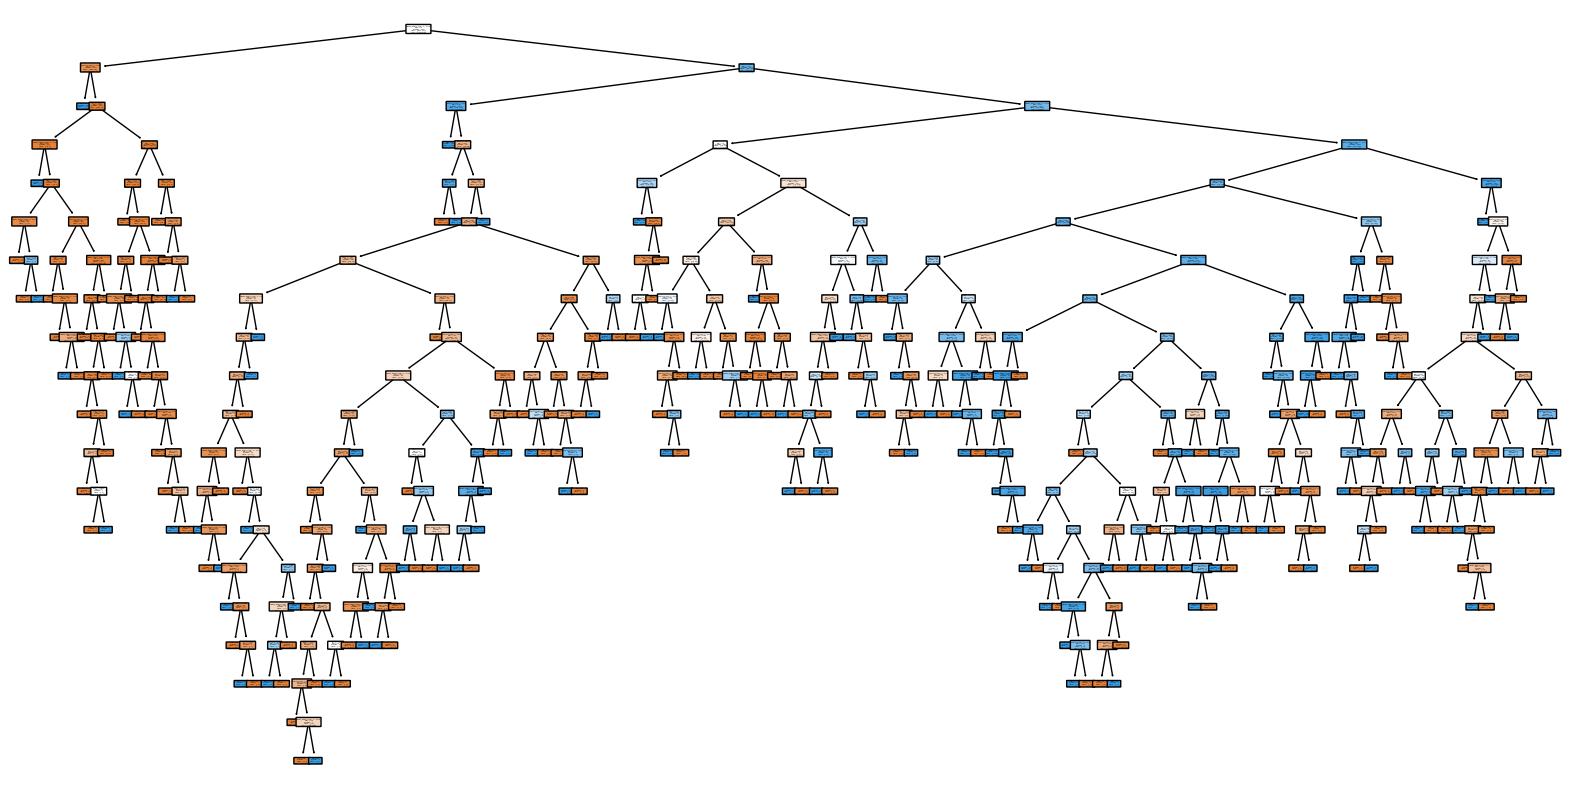

In [79]:
plt.figure(figsize=(20, 10))
plot_tree(rf_model.estimators_[0],
          feature_names=['DIA', 'MES', 'HORA', 'MINUTO', 'DURACION_DET', 'TIEMPO_DESDE_ULTIMA'],
          class_names=['No Detención', 'Detención'],
          filled=True,
          rounded=True)
plt.show()

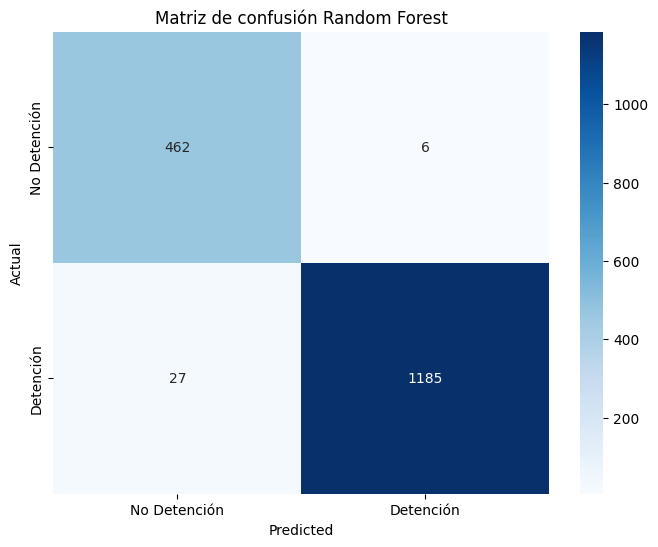

In [82]:
y_pred_rf = rf_model.predict(X_test)
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['No Detención', 'Detención'], yticklabels=['No Detención', 'Detención'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de confusión Random Forest')
plt.show()

SVM

In [84]:
svm_model = SVC()
svm_model.fit(X_train_smote, y_train_smote)
y_pred_svm = svm_model.predict(X_test)
print("SVM")
print(classification_report(y_test, y_pred_svm))
print(f"Precisión: {accuracy_score(y_test, y_pred_svm)}\n")

SVM
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       468
           1       0.99      0.97      0.98      1212

    accuracy                           0.97      1680
   macro avg       0.96      0.98      0.97      1680
weighted avg       0.97      0.97      0.97      1680

Precisión: 0.9738095238095238



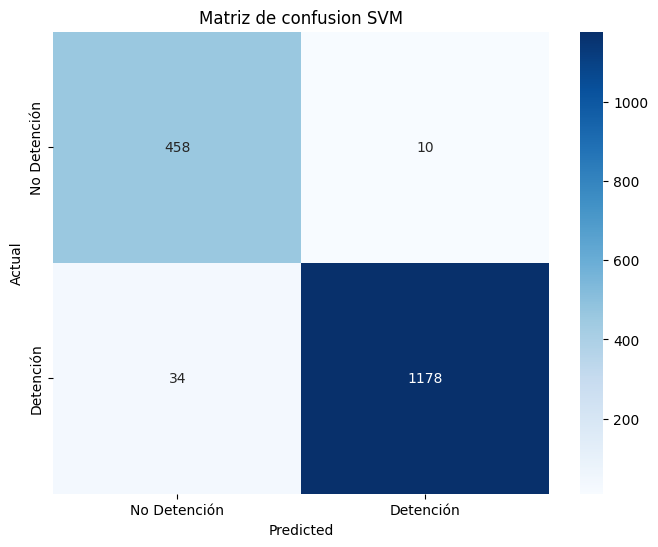

In [85]:
y_pred_svm = svm_model.predict(X_test)
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Detención', 'Detención'], yticklabels=['No Detención', 'Detención'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de confusion SVM')
plt.show()

# LSTM

Datos

In [86]:
time_steps = 10

In [87]:
X_train_smote = pd.DataFrame(X_train_smote).reset_index(drop=True)
y_train_smote = pd.Series(y_train_smote).reset_index(drop=True)
X_test = pd.DataFrame(X_test).reset_index(drop=True)
y_test = pd.Series(y_test).reset_index(drop=True)

In [88]:
train_generator = TimeseriesGenerator(X_train_smote, y_train_smote, length=time_steps, batch_size=32)
test_generator = TimeseriesGenerator(X_test, y_test, length=time_steps, batch_size=32)

Modelo

In [89]:
lstm_model = Sequential()
lstm_model.add(LSTM(150, activation='relu', return_sequences=True, input_shape=(time_steps, X_train_smote.shape[1])))
lstm_model.add(Dropout(0.5))
lstm_model.add(LSTM(100, activation='relu', return_sequences=True))
lstm_model.add(Dropout(0.5))
lstm_model.add(LSTM(50, activation='relu'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [90]:
optimizer = Adam(learning_rate=0.001)

In [91]:
lstm_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [92]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [93]:
history = lstm_model.fit(train_generator, epochs=30, validation_data=test_generator, callbacks=[early_stopping])

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


301/301 ━━━━━━━━━━━━━━━━━━━━ 26s 67ms/step - accuracy: 0.5747 - loss: 0.6840 - val_accuracy: 0.6928 - val_loss: 0.6226
Epoch 2/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 19s 63ms/step - accuracy: 0.7246 - loss: 0.5803 - val_accuracy: 0.7084 - val_loss: 0.6194
Epoch 3/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - accuracy: 0.7864 - loss: 0.4661 - val_accuracy: 0.7174 - val_loss: 0.6045
Epoch 4/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.7940 - loss: 0.4469 - val_accuracy: 0.7066 - val_loss: 0.6524
Epoch 5/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.7917 - loss: 0.4493 - val_accuracy: 0.7186 - val_loss: 0.6050
Epoch 6/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.7956 - loss: 0.4379 - val_accuracy: 0.7186 - val_loss: 0.5987
Epoch 7/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.8013 - loss: 0.4238 - val_accuracy: 0.7114 - val_loss: 0.6123
Epoch 8/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.8015 - loss: 0.4265 - val_accurac

In [94]:
loss, accuracy = lstm_model.evaluate(test_generator)
print(f"LSTM Accuracy: {accuracy}\n")

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7036 - loss: 0.6100
LSTM Accuracy: 0.7221556901931763



GRU

In [99]:
gru_model = Sequential()
gru_model.add(GRU(150, activation='relu', return_sequences=True, input_shape=(time_steps, X_train_smote.shape[1])))
gru_model.add(Dropout(0.5))
gru_model.add(GRU(100, activation='relu', return_sequences=True))
gru_model.add(Dropout(0.5))
gru_model.add(GRU(50, activation='relu'))
gru_model.add(Dropout(0.5))
gru_model.add(Dense(1, activation='sigmoid'))

In [100]:
optimizer = Adam(learning_rate=0.001)
gru_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [101]:
history = gru_model.fit(train_generator, epochs=30, validation_data=test_generator, callbacks=[early_stopping])


Epoch 1/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 31s 76ms/step - accuracy: 0.5336 - loss: 0.6772 - val_accuracy: 0.6695 - val_loss: 0.6611
Epoch 2/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 21s 70ms/step - accuracy: 0.7542 - loss: 0.5182 - val_accuracy: 0.7042 - val_loss: 0.6525
Epoch 3/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 34s 48ms/step - accuracy: 0.7836 - loss: 0.4635 - val_accuracy: 0.7180 - val_loss: 0.5973
Epoch 4/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.7854 - loss: 0.4623 - val_accuracy: 0.7204 - val_loss: 0.6020
Epoch 5/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.8036 - loss: 0.4175 - val_accuracy: 0.7168 - val_loss: 0.6036


In [103]:
loss, accuracy = gru_model.evaluate(test_generator)
print(f"GRU Accuracy: {accuracy}\n")

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6362 - loss: 0.6816
GRU Accuracy: 0.6694610714912415

